

# K Nearest Neighbours

### L’objectif de ce TD est d'écrire un programme complet de classification d'images à base de KPPV





In [ ]:
# Importer les libraires nécesssaire:
import numpy as np
import _pickle as cPickle
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from skimage import data
from skimage import color
from skimage.util import view_as_blocks

import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import numpy as np



### La méthode des K plus proches voisins (KNN) a pour but de classifier des points cibles en fonction de leurs distances par rapport à des points constituant un échantillon d’apprentissage 

# Développement du classifieur

## 1- Lecture des données

### La fonction lecture_cifar prend en entrée le chemin d'un fichier de donnée et retourne la matrice des variables X et la matrice des classes Y . Elle prend également le soin de convertir la classe int8 en int32 , ce qui sera utile par la suite pour calculer la matrice de distances.

In [ ]:
def lecture_cifar(path):
    dict=[]
    for i in range(1,6):
        file=path+"data_batch_"+str(i)
        with open (file,"rb") as fo:
            dict.append(pickle.load(fo,encoding="bytes"))
            
    file=path+ "test_batch"   
    with open (file,"rb") as fo:
        dict.append(pickle.load(fo,encoding="bytes"))
    
    X=dict[0][b"data"]
    Y=dict[0][b"labels"]
    for i in range(1,6):
        X=np.vstack((X,dict[i][b"data"]))
        Y+=dict[i][b"labels"]
        
    X=np.float32(X)
    Y=np.array(Y)
        
    return X,Y

X,Y=lecture_cifar("cifar-10-batches-py/")

print(X)


[[ 59.  43.  50. ... 140.  84.  72.]
 [154. 126. 105. ... 139. 142. 144.]
 [255. 253. 253. ...  83.  83.  84.]
 ...
 [ 20.  19.  15. ...  50.  53.  47.]
 [ 25.  15.  23. ...  80.  81.  80.]
 [ 73.  98.  99. ...  94.  58.  26.]]


In [ ]:
print(Y)


[6 9 9 ... 5 1 7]


## 2- Découpage des données

### il faut découper le jeu de données en un jeu d'apprentissage et un jeu de test. On décide de prendre une proportion de 80% pour le jeu d'apprentissage et de 20% pour le jeu de test. 

In [ ]:
"""
def decoupage_donnees ( X,Y,ratio=0.8,essai=False):
    N=X.shape[0]
    indices=np.array(range(N))
    np.random.shuffle(indices)
    
    M=int(ratio*N)
    
    if(essai):
        Xapp=X[idices[:500],:]
        Yapp=Y[idices[:500]]
        
        Xtest=X[idices[-100:],:]
        Ytest=Y[idices[-100:]]        

        return Xapp, Xtest, Yapp, Yest 
    
    M=int(ratio*N)

    Xapp = X[indices[:M],:]
    Yapp = Y[indices[:M]]
        
    Xtest = X[indices[M:],:]
    Ytest = Y[indices[M:]]
    
    return Xapp, Xtest, Yapp, Ytest
    

Xapp, Xtest, Yapp, Ytest=decoupage_donnees( X,Y)
print(Xapp, Xtest, Yapp, Ytest)   

"""

def decoupage_donnees(X, Y):
    Xapp, Xtest, Yapp, Ytest = train_test_split(X, Y, train_size=0.8, test_size=0.2,
    shuffle=False, random_state=None)
    return Xapp, Xtest, Yapp, Ytest

Xapp, Xtest, Yapp, Ytest= decoupage_donnees(X, Y)

Xtest1=Xtest[0:2000,:]
Ytest1=Ytest[0:2000]
Xapp1=Xapp[0:8000,:]
Yapp1=Yapp[0:8000]

print(Yapp1.shape)

(8000,)


## 3-kppv_distances

### Chaque image est représentée par un vecteur de taille 3072. La distance entre deux images est définie comme la norme euclidienne entre les vecteurs de ces images. Le code ci-dessous calcule la matrice de distance entre le jeu de test et le jeu d'apprentissage. La valeur (i, j) de cette matrice représente la distance (au carré) de la i-ème image du jeu de test par rapport à la j-ème image du jeu d'apprentissage.

In [ ]:
def somme_carres_Xapp(X, d):
    A = X**2
    Ones = np.ones((d, 1))
    B = np.dot(A, Ones)
    return B.T
def somme_carres_Xtest(X, d):
    A = X**2
    Ones = np.ones((d, 1))
    B = np.dot(A, Ones)
    return B
def kppv_distances(Xapp, Xtest):
    n = Xapp1.shape[0]
    m = Xtest1.shape[0]
    d = Xapp1.shape[1]
    Xprod = np.dot(Xtest1, Xapp.T)
    Xapp_carre = somme_carres_Xapp(Xapp1, d)
    Xtest_carre = somme_carres_Xtest(Xtest1, d)
    return -2*Xprod + Xapp_carre + Xtest_carre

Dist = kppv_distances(Xapp1, Xtest1)
dist = np.sqrt(Dist)

print(Dist)


[[2.06765530e+07 2.51649420e+07 3.63458980e+07 ... 2.37991140e+07
  2.50497790e+07 3.10197590e+07]
 [7.35439150e+07 5.55465040e+07 5.43805480e+07 ... 5.22893720e+07
  9.93341250e+07 1.00869241e+08]
 [3.28980470e+07 3.00543080e+07 3.01962320e+07 ... 1.62707120e+07
  4.92046690e+07 3.94459250e+07]
 ...
 [3.28040050e+07 2.85589300e+07 1.50962300e+07 ... 2.11829580e+07
  2.64783670e+07 2.49911870e+07]
 [3.52449600e+07 2.34845010e+07 2.05867050e+07 ... 2.15630170e+07
  4.25614580e+07 4.76523500e+07]
 [2.28966320e+07 2.28655090e+07 2.18391210e+07 ... 1.28642490e+07
  3.11106580e+07 2.66736540e+07]]


In [ ]:
print(dist)
print(dist.shape)

[[ 4547.14778735  5016.46708352  6028.75592473 ...  4878.43356007
   5004.97542452  5569.53849075]
 [ 8575.7748921   7452.95270346  7374.31678191 ...  7231.13905274
   9966.65064101 10043.36801078]
 [ 5735.68191238  5482.18095287  5495.10982602 ...  4033.69706349
   7014.60398027  6280.59909563]
 ...
 [ 5727.4780663   5344.05557606  3885.38672464 ...  4602.49475828
   5145.71345879  4999.11862232]
 [ 5936.74658378  4846.08099396  4537.25743153 ...  4643.59957361
   6523.91431581  6903.06815844]
 [ 4785.04252855  4781.78930945  4673.23453295 ...  3586.6765954
   5577.69289223  5164.65429627]]
(2000, 8000)


## kppv_predict

### Cette fonction prédit la classe pour chaque instance du jeu de test, en se basant sur ses k plus proches voisins (obtenus par la matrice de distances). On peut prendre une valeur de K = 3 pour commencer.

In [ ]:
k=3
def kppv_predict(Dist, Yapp, K):
    N=dist.shape[0]
    Ypred=np.zeros(N,dtype=int)
    
    for i in range(N):
        kppv=Yapp1[dist[i,:].argsort()[:K]]
        Ypred[i]=np.argmax(np.bincount(kppv))
        
    return Ypred

In [ ]:
Ypred=kppv_predict(dist, Yapp1,k )
print(Ypred)

[2 0 0 ... 2 8 2]


### Il faut maintenant évaluer les performances du classifieur. Un classifieur est bon si son 'accuracy' est grand, c'est-à-dire s'il arrive à correctement prédire la classe des instances du jeu de test.

## Evaluation_classifieur

In [ ]:
def evaluation_classifieur(Ytest1,Ypred):
    
    return (Ytest1==Ypred).sum()/Ytest1.shape[0]



In [ ]:
accuracy = evaluation_classifieur(Ypred, Ytest1)
print("L'accuracy du classifieur est de", accuracy)

L'accuracy du classifieur est de 0.2815


### Seuls 10,7 % des instances sont bien classées. Néanmoins, on peut reltiviser ce résultat: la résolution des images est très faible (32x32), les images sont très pixellisées. On peut supposer qu'avec une meilleure résolution, l'accuracy sera meilleure.

##  Expérimentations

### Le nombre de voisins à considérer peut avoir une influence sur l'accuracy. Pour le voir, traçons l'accuracy en fonction de K:

In [ ]:
# influence du nombre de voisins K 
#sur l'efficacité du classifieur évaluée à l'aide du taux de classification (Accuracy).

Ks = []
accuracies = []
for K in range (1,10):
    Ypred = kppv_predict(dist, Yapp1, K)
    accuracy = evaluation_classifieur( Ytest1,Ypred)
    Ks.append(K)
    accuracies.append(accuracy)

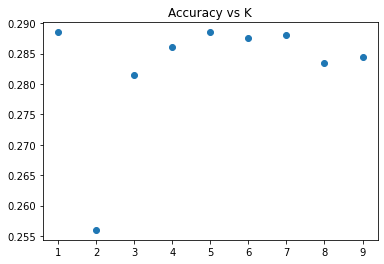

In [ ]:
import matplotlib.pyplot as plt
plt.plot(Ks, accuracies, 'o')
plt.title('Accuracy vs K')
plt.show()

In [ ]:
best_K = np.argmax(accuracies)+1
print("La valeur de K qui donne le meilleur score d'accuracy est K = ", best_K)

La valeur de K qui donne le meilleur score d'accuracy est K =  1


### On garde alors la valeur de K = 1 pour la suite.

## Validation croisée

### Il faut également vérifier que notre algorithme de classification n'a pas fait du surapprentissage (overtiffing). Pour cela, on fait de la validation croisée à 10 échantillons.

### On définit tout d'abord une fonction run_classifier qui réunit les fonctions définies précédemment.

In [ ]:
def run_classifier(Xapp, Yapp, Xtest, Ytest, K):
    dist = kppv_distances(Xapp1, Xtest1)
    dist = np.sqrt(dist)
    Ypred = kppv_predict(dist, Yapp1, K)
    accuracy = evaluation_classifieur(Ypred, Ytest1)
    return Ypred, accuracy

In [ ]:
from sklearn.model_selection import KFold
N=4
kf = KFold(n_splits=N)
predictions = []
accuracies = []
for train_index, test_index in kf.split(Xapp1):
    Xapp2, Xtest2 = Xapp1[train_index], Xapp1[test_index]
    Yapp2, Ytest2 = Yapp1[train_index], Yapp1[test_index]
    Ypred2, accuracy2 = run_classifier(Xapp2, Yapp2, Xtest2, Ytest2, best_K)
    accuracies.append(accuracy2)
    
print('La moyenne des accuracies est ', np.mean(accuracies))

La moyenne des accuracies est  0.2885
